In [1]:
import pandas as pd
import datetime as dt

In [2]:
aapl_text = pd.read_csv('../data/cleaned_AAPL_NEWS.csv')
aapl_finance = pd.read_csv('../data/AAPL_FULL_FINANCIAL.csv')


aapl_text['date'] = pd.to_datetime(aapl_text['date'], errors='coerce', utc=True)
aapl_finance['Date'] = pd.to_datetime(aapl_finance['Date'], errors='coerce', utc=True)

# Check the data types to ensure they were properly converted
print(aapl_text['date'].dtype)  # Should be datetime64[ns, UTC]
print(aapl_finance['Date'].dtype)  # Should be datetime64[ns, UTC]

datetime64[ns, UTC]
datetime64[ns, UTC]


In [3]:
aapl_text['Date'] = aapl_text['date'].dt.date
aapl_finance['Date'] = aapl_finance['Date'].dt.date

aapl_text.drop('date',axis=1, inplace=True)


In [4]:
aapl_df = pd.merge(aapl_finance, aapl_text, on='Date', how='left')
# print(aapl_df.columns)
aapl_df.drop('Unnamed: 0_x', axis = 1, inplace=True)
aapl_df.drop('Unnamed: 0_y', axis = 1, inplace=True)

print(aapl_df.head(40))

          Date      Close  Label     SMA_20     EMA_20      MACD  Signal_Line  \
0   2019-11-11  63.549580      0        NaN  63.549580  0.000000     0.000000   
1   2019-11-12  63.491405      1        NaN  63.544039 -0.004641    -0.000928   
2   2019-11-13  64.099770     -1        NaN  63.596966  0.040307     0.007319   
3   2019-11-14  63.656223      1        NaN  63.602609  0.039680     0.013791   
4   2019-11-15  64.412422      0        NaN  63.679735  0.099061     0.030845   
5   2019-11-18  64.737206     -1        NaN  63.780446  0.170363     0.058749   
6   2019-11-19  64.540878      0        NaN  63.852868  0.208625     0.088724   
7   2019-11-20  63.789539      0        NaN  63.846837  0.176288     0.106237   
8   2019-11-21  63.503529      0        NaN  63.814141  0.126128     0.110215   
9   2019-11-22  63.447792      1        NaN  63.779250  0.080946     0.104361   
10  2019-11-25  64.560272     -1        NaN  63.853633  0.133369     0.110163   
11  2019-11-26  64.056145   

In [5]:
print(aapl_df.columns)

Index(['Date', 'Close', 'Label', 'SMA_20', 'EMA_20', 'MACD', 'Signal_Line',
       'High_20', 'Low_20', 'Fib_23.6', 'Fib_38.2', 'Fib_61.8', '%K', '%D',
       'BB_Mid', 'BB_Upper', 'BB_Lower', 'RSI', 'Std_Dev_20', 'top_5_titles'],
      dtype='object')


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from transformers import pipeline
import string
from sklearn.preprocessing import MinMaxScaler




/Users/bobbytomlinson/Desktop/Coding/School/CS 549/financialTrendForecasting/ftfVenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Shift the 'Close' column to get the next day's closing price as the target
aapl_df['Next_Close'] = aapl_df['Close'].shift(-1)  # Shift up by one to predict the next day

# Drop the last row as it now has a NaN target
aapl_df = aapl_df.dropna(subset=['Next_Close'])

In [8]:
# Initialize VADER Sentiment analyzer
vader_analyzer = SentimentIntensityAnalyzer()

# Initialize HuggingFace sentiment analysis model
transformer_analyzer = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [9]:
def textblob_sentiment(text):
    if not text or isinstance(text, float):  # Check for NaN or empty string
        return 0  # Neutral sentiment for missing text
    return TextBlob(text).sentiment.polarity

In [10]:
def vader_sentiment(text):
    if not text or isinstance(text, float):  # Check for NaN or empty string
        return 0  # Neutral sentiment for missing text
    return vader_analyzer.polarity_scores(text)['compound']

In [11]:
def bow_sentiment(text, vectorizer=None):
    if not text or isinstance(text, float):  # Check for NaN or empty string
        return 0  # Neutral sentiment for missing text
    if vectorizer is None:
        vectorizer = CountVectorizer(stop_words='english')
        vectorizer.fit([text])  # Fit on a single sentence
    word_vector = vectorizer.transform([text]).toarray()
    return word_vector.mean()  # Using the mean of the feature vector as a basic sentiment score

In [12]:
def transformer_sentiment(text):
    if not text or isinstance(text, float):  # Check for NaN or empty string
        return 0  # Neutral sentiment for missing text
    result = transformer_analyzer(text)
    return 1 if result[0]['label'] == 'POSITIVE' else -1

In [13]:
def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = ''.join([char for char in text if char not in string.punctuation])
        return text
    return '' # Replace NaN or non-strings with 'missing'

In [14]:
def plot_predictions(y_test, predictions, title):
    plt.figure(figsize=(10, 5))
    plt.plot(y_test, label='Actual Next Day Close', color='blue')
    plt.plot(predictions, label='Predicted Next Day Close', color='orange', linestyle='--')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()


In [15]:
aapl_df['cleaned_text'] = aapl_df['top_5_titles'].apply(preprocess_text)
aapl_df.drop('top_5_titles', axis = 1, inplace=True)


In [16]:
sentiment_methods = {
    'textblob': aapl_df['cleaned_text'].apply(textblob_sentiment),
    'vader': aapl_df['cleaned_text'].apply(vader_sentiment),
    'bow': aapl_df['cleaned_text'].apply(lambda x: bow_sentiment(x)),
    'transformer': aapl_df['cleaned_text'].apply(transformer_sentiment)
}

In [17]:
aapl_df = aapl_df.dropna()
nan_counts = aapl_df.isna().sum()
print("Columns with NaN values and their counts:\n", nan_counts[nan_counts > 0])

Columns with NaN values and their counts:
 Series([], dtype: int64)


In [18]:
# new targets
aapl_df['Close_5d_Future'] = aapl_df['Close'].shift(-5)  # Shift to get the 5-day future close price
aapl_df['Pct_Change_5d'] = ((aapl_df['Close_5d_Future'] - aapl_df['Close']) / aapl_df['Close']) * 100
aapl_df.dropna(inplace=True)  # Drop rows with NaNs introduced by shifting

In [19]:
datasets = {}
for method, sentiment in sentiment_methods.items():
    aapl_df_temp = aapl_df.copy()
    aapl_df_temp[method + '_sentiment'] = sentiment
    datasets[method] = aapl_df_temp



In [20]:
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))  # Explicit input layer
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))  # Output layer for regression with linear activation
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [21]:
def train_and_evaluate_lstm(X_train, y_train, X_test, y_test):
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = create_lstm_model(input_shape)
    
    # Fit the model
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    
    # Make predictions
    predictions = model.predict(X_test)
    
    # Calculate performance metrics
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    return model, predictions, mse, r2, history



In [22]:
# Plotting training and validation loss
def plot_training_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [23]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# Define a simpler set of financial features
financial_features = ['SMA_20', 'EMA_20', 'MACD', 'RSI', 'BB_Mid']

# Set up results dictionary to store performance of each model
results = {}

# Baseline Model (without sentiment analysis)
X_baseline = aapl_df[financial_features]
y = aapl_df['Pct_Change_5d']  # Predicting percentage change over 5 days

# Scale baseline data
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_baseline_scaled = scaler_X.fit_transform(X_baseline)
y = y.values  # No need to scale y for percentage change prediction

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_baseline_scaled, y, test_size=0.2, random_state=42)

# Train and evaluate the baseline Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
predictions = lr_model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
results['baseline'] = (mse, r2)
predictions_dict = {'baseline': predictions}

# Sentiment Models
for method, dataset in datasets.items():
    # Use financial indicators and sentiment score as features
    X = dataset[financial_features + [method + '_sentiment']]
    y = dataset['Pct_Change_5d']

    # Scale data
    X_scaled = scaler_X.fit_transform(X)
    y = y.values  # Target remains as percentage change

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    # Train and evaluate the Linear Regression model
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    predictions = lr_model.predict(X_test)

    # Calculate performance metrics
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    results[method] = (mse, r2)
    
    # Store predictions for later plotting
    predictions_dict[method] = predictions
    
    print(f"Results for {method}: MSE={mse:.4f}, R²={r2:.4f}")

# Determine the best sentiment method based on R² score
best_method = max(results, key=lambda k: results[k][1])
print(f"Best performing sentiment analysis method for 5-day price change prediction: {best_method}")


Results for textblob: MSE=19.1246, R²=-0.0122
Results for vader: MSE=18.9143, R²=-0.0011
Results for bow: MSE=19.0769, R²=-0.0097
Results for transformer: MSE=19.1231, R²=-0.0121
Best performing sentiment analysis method for 5-day price change prediction: vader


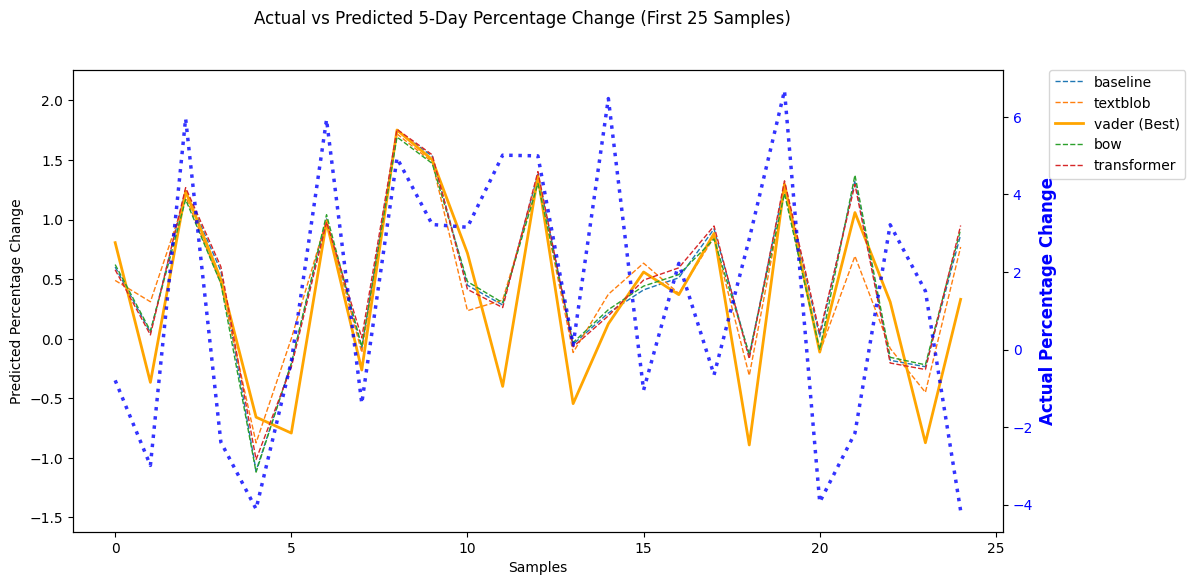

Baseline Results: MSE=19.1103, R²=-0.0115
Textblob Results: MSE=19.1246, R²=-0.0122
Vader Results: MSE=18.9143, R²=-0.0011
Bow Results: MSE=19.0769, R²=-0.0097
Transformer Results: MSE=19.1231, R²=-0.0121

Best performing model: Vader


In [24]:
# Define the number of samples to plot for better readability
num_samples = 25  # Display the first 100 samples

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the actual 5-day percentage change on a secondary y-axis
ax2 = ax1.twinx()
ax2.plot(y_test[:num_samples], label='Actual 5-day % Change', color='blue', linewidth=2.5, linestyle=':', alpha=0.8)
ax2.set_ylabel('Actual Percentage Change', color='blue', fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='blue')

# Plot each model's predictions on the primary y-axis, highlighting the best model
for method, predictions in predictions_dict.items():
    if method == best_method:
        ax1.plot(predictions[:num_samples], label=f'{method} (Best)', linestyle='-', linewidth=2, color='orange')
    else:
        ax1.plot(predictions[:num_samples], label=f'{method}', linestyle='--', linewidth=1)

# Set y-axis limits for predictions to improve readability
pred_min = min(min(pred[:num_samples]) for pred in predictions_dict.values())
pred_max = max(max(pred[:num_samples]) for pred in predictions_dict.values())
ax1.set_ylim(pred_min - 0.5, pred_max + 0.5)
ax1.set_ylabel('Predicted Percentage Change')
ax1.set_xlabel('Samples')

# Add legend and title, with a larger font for the actual line in the legend
fig.suptitle(f'Actual vs Predicted 5-Day Percentage Change (First {num_samples} Samples)')
ax1.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0., fontsize=10)
plt.show()

# Print results for each model
for method, (mse, r2) in results.items():
    print(f"{method.capitalize()} Results: MSE={mse:.4f}, R²={r2:.4f}")
print(f"\nBest performing model: {best_method.capitalize()}")


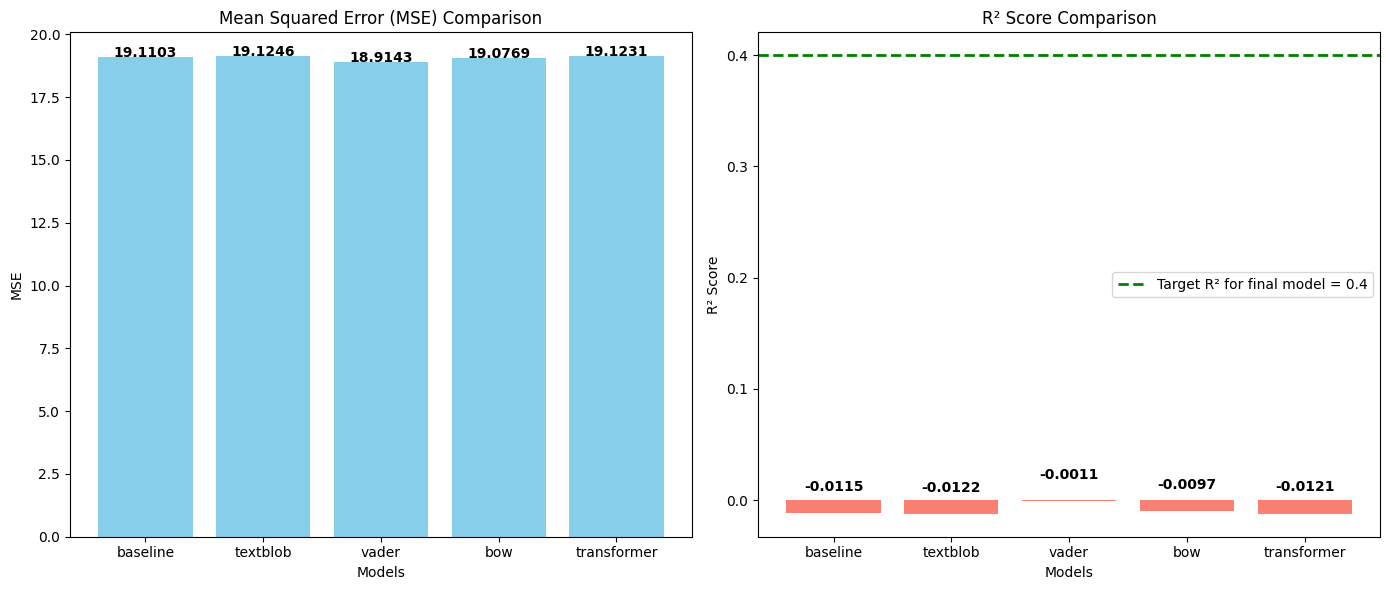

In [26]:
# Extract model names, MSE, and R² values
model_names = list(results.keys())
mse_values = [results[model][0] for model in model_names]
r2_values = [results[model][1] for model in model_names]

# Plot MSE for each model
plt.figure(figsize=(14, 6))

# MSE bar chart
plt.subplot(1, 2, 1)
plt.bar(model_names, mse_values, color='skyblue')
plt.title('Mean Squared Error (MSE) Comparison')
plt.xlabel('Models')
plt.ylabel('MSE')
for i, v in enumerate(mse_values):
    plt.text(i, v + 0.0005, f'{v:.4f}', ha='center', fontweight='bold')

# R² bar chart with target line
plt.subplot(1, 2, 2)
plt.bar(model_names, r2_values, color='salmon')
plt.axhline(y=0.4, color='green', linestyle='--', linewidth=2, label='Target R² for final model = 0.4')
plt.title('R² Score Comparison')
plt.xlabel('Models')
plt.ylabel('R² Score')
for i, v in enumerate(r2_values):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()
